# 로지스틱 회귀모델 구축 with MLflow
- 데이터셋 출처 : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud    
  개인정보를 제거하고 주성분 분석(PCA) 처리가 된 데이터입니다.  

##

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import KFold

import mlflow
import mlflow.sklearn

print("numpy: {}".format(np.__version__))
print("pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))

numpy: 1.26.4
pandas: 2.2.1
matplotlib: 3.8.3
seaborn: 0.13.2
sklearn: 1.4.1.post1


In [2]:
# from google.colab import files
# uploaded = files.upload()

Time 컬럼이 이상 징후를 찾는 데 유용하지 않고, 복잡성만 가중시키는 것을 확인 되어서 삭제합니다.

In [3]:
df = pd.read_csv('creditcard.csv')
df = df.drop('Time', axis=1)

In [4]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

In [6]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 30)
Anomaly: (492, 30)


In [7]:
df[df.Class == 0].shape

(284315, 30)

In [8]:
normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state = 2020)

In [9]:
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state = 2020)

In [10]:
normal_train, normal_validate = train_test_split(normal_train, test_size = 0.25, random_state = 2020)

anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

In [11]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

In [12]:
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

In [13]:
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [14]:
print(f"Training sets:\nx_train: {x_train.shape} y_train: {y_train.shape}")
print(f"\nTesting sets:\nx_test: {x_test.shape} y_test: {y_test.shape}")
print(f"\nValidation sets:\nx_validate: {x_validate.shape} y_validate: {y_validate.shape}")

Training sets:
x_train: (85588, 29) y_train: (85588,)

Testing sets:
x_test: (28531, 29) y_test: (28531,)

Validation sets:
x_validate: (28531, 29) y_validate: (28531,)


In [15]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

## MLFlow를 통한 학습 및 평가

In [16]:
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

In [17]:
def evaluate(sk_model, x_test, y_test):
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict(x_test)
    auc_score = roc_auc_score(y_test, preds)
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    print(f"Eval Accuracy: {eval_acc:.3%}")
    print(f"Auc Score: {auc_score:.3%}")
    roc_plot = RocCurveDisplay.from_estimator(sk_model, x_test, y_test, name="scikit-learn ROC Curve")
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt="g")
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

## MLFlow 실행 로깅 및 확인
- 아래 셀을 여러번 실행해서 MLflow UI 에서 확인합니다. : mlflow ui -p 1234


Train Accuracy: 99.894%
Eval Accuracy: 99.874%
Auc Score: 85.341%


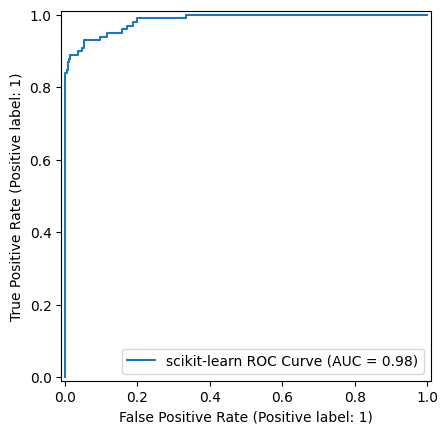

D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model run: 22fad67c207e4848a82668a4b2c7f2a8


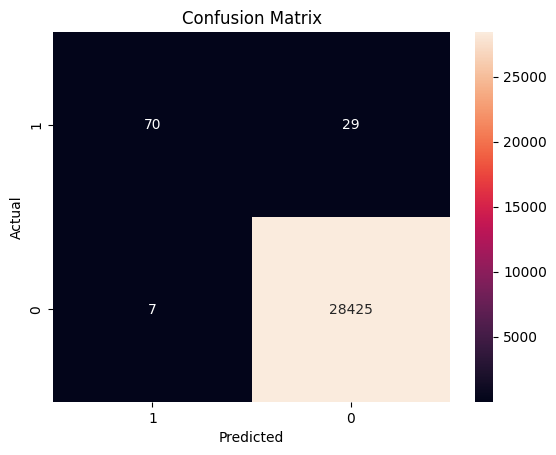

In [21]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg').fit(x_train, y_train)
mlflow.set_experiment("scikit_learn_experiment")
with mlflow.start_run():
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model, "log_reg_model")
    print(f"Model run: {mlflow.active_run().info.run_id}")
mlflow.end_run()

### 로깅된 모델 적재

In [22]:
# loaded_model = mlflow.sklearn.load_model("runs:/<run_id>/log_reg_model")
loaded_model = mlflow.sklearn.load_model(
    "runs:/22fad67c207e4848a82668a4b2c7f2a8/log_reg_model"
)

In [23]:
loaded_model.score(x_test, y_test)

0.9987382145736217

## MLflow를 사용한 모델 검증(파라미터 튜닝)

### 광범위한 검색

In [24]:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2024)

In [25]:
mlflow.set_experiment("scikit_creditcard_broad_search")

logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight", weight)
            class_weights = {
                0: 1, 
                1: weight
            }
            sk_model = LogisticRegression(
                random_state=None,
                max_iter=400,
                solver="newton-cg",
                class_weight=class_weights,
            ).fit(x_validate[train], y_validate[train])
            print("-" * 40)
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(x_validate[train], y_validate[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            mlflow.log_metric("auc_score", auc_score)
            print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

2024/04/01 10:30:21 INFO mlflow.tracking.fluent: Experiment with name 'scikit_creditcard_broad_search' does not exist. Creating a new experiment.


----------------------------------------

fold 1
Anomaly Weight: 1
AUC: 0.8749121419785626
eval_acc: 0.9991238829507623


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 2
Anomaly Weight: 1
AUC: 0.8539906722984866
eval_acc: 0.998422712933754


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 3
Anomaly Weight: 1
AUC: 0.8749120647203659
eval_acc: 0.9989484752891693


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 4
Anomaly Weight: 1
AUC: 0.8570549063952759
eval_acc: 0.9987732211706976


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 5
Anomaly Weight: 1
AUC: 0.7496483825597748
eval_acc: 0.9977216964598669


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Averages: 
Accuracy:  0.9985979977608499
AUC:  0.8421036335904931
Best: 
Accuracy:  0.9991238829507623
AUC:  0.8749121419785626
----------------------------------------

fold 1
Anomaly Weight: 5
AUC: 0.9996485679142505
eval_acc: 0.9992991063606098


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 2
Anomaly Weight: 5
AUC: 0.8744720168954594
eval_acc: 0.9978969505783386


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 3
Anomaly Weight: 5
AUC: 0.9498241294407316
eval_acc: 0.9992989835261129


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 4
Anomaly Weight: 5
AUC: 0.9284834778238473
eval_acc: 0.9992989835261129


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 5
Anomaly Weight: 5
AUC: 0.832893811533052
eval_acc: 0.9980722046968104


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Averages: 
Accuracy:  0.998773245737597
AUC:  0.9170644007214681
Best: 
Accuracy:  0.9992991063606098
AUC:  0.9996485679142505
----------------------------------------

fold 1
Anomaly Weight: 10
AUC: 0.9992971358285012
eval_acc: 0.9985982127212195


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 2
Anomaly Weight: 10
AUC: 0.8951293558606124
eval_acc: 0.9977216964598669


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 3
Anomaly Weight: 10
AUC: 0.9497361941610974
eval_acc: 0.999123729407641


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 4
Anomaly Weight: 10
AUC: 0.9282196255811032
eval_acc: 0.9987732211706976


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 5
Anomaly Weight: 10
AUC: 0.8326300984528833
eval_acc: 0.997546442341395


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Averages: 
Accuracy:  0.9983526604201641
AUC:  0.9210024819768396
Best: 
Accuracy:  0.999123729407641
AUC:  0.9992971358285012
----------------------------------------

fold 1
Anomaly Weight: 15
AUC: 0.999033561764189
eval_acc: 0.9980725424916769


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 2
Anomaly Weight: 15
AUC: 0.9156107004575853
eval_acc: 0.9971959341044515


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 3
Anomaly Weight: 15
AUC: 0.949560323601829
eval_acc: 0.9987732211706976


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 4
Anomaly Weight: 15
AUC: 0.9279557733383591
eval_acc: 0.9982474588152822


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 5
Anomaly Weight: 15
AUC: 0.8326300984528833
eval_acc: 0.997546442341395

Averages: 
Accuracy:  0.9979671197847007
AUC:  0.9249580915229692
Best: 
Accuracy:  0.9987732211706976
AUC:  0.999033561764189


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### MLflow UI 에서 검색을 해 보세요.
metrics."auc_score" >= 0.90   
metrics."auc_score" >= 0.9 AND parameters.anomaly_weight = "5"   
parameters.anomaly_weight = "1"   
parameters.anomaly_weight = "5"   
parameters.anomaly_weight = "10"  
parameters.anomaly_weight = "15"   

## 파라미터 튜닝 - Guided Search
- 전체적으로는 이상 가중치가 10과 15로 가장 높았지만, 이상 가중치가 증가할 수록 상승추세인거 같습니다.   
- 더 광범위한 이상 가중치를 사용해 검증을 다시 실행해봅니다.   


In [26]:
anomaly_weights = [10, 50, 100, 150, 200]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2024)

In [27]:
mlflow.set_experiment("scikit_creditcard_guided_search")

logs = []
for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    for train, test in kfold.split(x_validate, y_validate):
        with mlflow.start_run():
            weight = anomaly_weights[f]
            mlflow.log_param("anomaly_weight", weight)
            class_weights = {0: 1, 1: weight}
            sk_model = LogisticRegression(
                random_state=None,
                max_iter=400,
                solver="newton-cg",
                class_weight=class_weights,
            ).fit(x_validate[train], y_validate[train])
            print("-" * 40)
            print(f"\nfold {fold}\nAnomaly Weight: {weight}")
            train_acc = sk_model.score(x_validate[train], y_validate[train])
            mlflow.log_metric("train_acc", train_acc)
            eval_acc = sk_model.score(x_validate[test], y_validate[test])
            preds = sk_model.predict(x_validate[test])
            mlflow.log_metric("eval_acc", eval_acc)

            try:
                auc_score = roc_auc_score(y_validate[test], preds)
            except:
                auc_score = -1
            mlflow.log_metric("auc_score", auc_score)
            print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))
            accuracies.append(eval_acc)
            auc_scores.append(auc_score)
            log = [sk_model, x_validate[test], y_validate[test], preds]
            logs.append(log)
            mlflow.sklearn.log_model(sk_model, f"anom_weight_{weight}_fold_{fold}")
            fold = fold + 1
            mlflow.end_run()
    print("\nAverages: ")
    print("Accuracy: ", np.mean(accuracies))
    print("AUC: ", np.mean(auc_scores))
    print("Best: ")
    print("Accuracy: ", np.max(accuracies))
    print("AUC: ", np.max(auc_scores))

2024/04/01 10:32:37 INFO mlflow.tracking.fluent: Experiment with name 'scikit_creditcard_guided_search' does not exist. Creating a new experiment.


----------------------------------------

fold 1
Anomaly Weight: 10
AUC: 0.9992971358285012
eval_acc: 0.9985982127212195


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 2
Anomaly Weight: 10
AUC: 0.8951293558606124
eval_acc: 0.9977216964598669


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 3
Anomaly Weight: 10
AUC: 0.9497361941610974
eval_acc: 0.999123729407641


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 4
Anomaly Weight: 10
AUC: 0.9282196255811032
eval_acc: 0.9987732211706976


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 5
Anomaly Weight: 10
AUC: 0.8326300984528833
eval_acc: 0.997546442341395


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Averages: 
Accuracy:  0.9983526604201641
AUC:  0.9210024819768396
Best: 
Accuracy:  0.999123729407641
AUC:  0.9992971358285012
----------------------------------------

fold 1
Anomaly Weight: 50
AUC: 0.9971885433140046
eval_acc: 0.9943928508848782


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 2
Anomaly Weight: 50
AUC: 0.9144667370644141
eval_acc: 0.9949176305643183


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 3
Anomaly Weight: 50
AUC: 0.9478895532887796
eval_acc: 0.9954433929197336


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 4
Anomaly Weight: 50
AUC: 0.9268124136198015
eval_acc: 0.995969155275149


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 5
Anomaly Weight: 50
AUC: 0.8310478199718705
eval_acc: 0.9943918682089029


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Averages: 
Accuracy:  0.9950229795705964
AUC:  0.923481013451774
Best: 
Accuracy:  0.995969155275149
AUC:  0.9971885433140046
----------------------------------------

fold 1
Anomaly Weight: 100
AUC: 0.9940256545422598
eval_acc: 0.9880848081303663


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 2
Anomaly Weight: 100
AUC: 0.9132347764871525
eval_acc: 0.9924640729057133


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 3
Anomaly Weight: 100
AUC: 0.9457791065775588
eval_acc: 0.9912372940764108


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 4
Anomaly Weight: 100
AUC: 0.9244377434351049
eval_acc: 0.9912372940764108


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 5
Anomaly Weight: 100
AUC: 0.8290260196905765
eval_acc: 0.9903610234840519


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Averages: 
Accuracy:  0.9906768985345906
AUC:  0.9213006601465304
Best: 
Accuracy:  0.9924640729057133
AUC:  0.9940256545422598
----------------------------------------

fold 1
Anomaly Weight: 150
AUC: 0.9913020558777017
eval_acc: 0.982652882425092


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 2
Anomaly Weight: 150
AUC: 0.9116508271735304
eval_acc: 0.9893094987732212


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 3
Anomaly Weight: 150
AUC: 0.9435807245867043
eval_acc: 0.9868559411146162


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 4
Anomaly Weight: 150
AUC: 0.9459605478075134
eval_acc: 0.9868559411146162


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 5
Anomaly Weight: 150
AUC: 0.8548699015471167
eval_acc: 0.9866806869961444


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Averages: 
Accuracy:  0.986470990084738
AUC:  0.9294728113985133
Best: 
Accuracy:  0.9893094987732212
AUC:  0.9913020558777017
----------------------------------------

fold 1
Anomaly Weight: 200
AUC: 0.9890177473203303
eval_acc: 0.9780970737690555


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 2
Anomaly Weight: 200
AUC: 0.9314281942977825
eval_acc: 0.9873817034700315


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 3
Anomaly Weight: 200
AUC: 0.9410306014773127
eval_acc: 0.9817735716789344


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 4
Anomaly Weight: 200
AUC: 0.9439376806131423
eval_acc: 0.9828250963897651


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


----------------------------------------

fold 5
Anomaly Weight: 200
AUC: 0.8531118143459916
eval_acc: 0.9831756046267087

Averages: 
Accuracy:  0.982650609986899
AUC:  0.9317052076109118
Best: 
Accuracy:  0.9873817034700315
AUC:  0.9890177473203303


D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
D:\강의자료\MLflow\py311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### MLflow UI AUC 점수를 내림차순으로 정렬하고 검색을 해 보세요.
parameters.anomaly_weight = "10"   
parameters.anomaly_weight = "50"   
parameters.anomaly_weight = "100"  
parameters.anomaly_weight = "150"   
parameters.anomaly_weight = "200"   